# Pythagorean three-body problem-WorkPrecision

<ul id="top">
<li><a href="#Loading-packages"> 
             Loading Packages</a></li>
    
<li><a href="#Computer-properties"> 
             Computer properties</a></li>  

<li><a href="#Initial-value-problem">
             Initial value problem</a></li>

<li><a href="#Test-solution">
             Test solution</a></li>
             
<li><a href="#Work-Precision-diagrams-(Float64)">
             Work-Precision diagrams (Float64)</a></li> 

<li><a href="#Work-Precision-diagrams-(Float128)">
             Work-Precision diagrams (Float128)</a></li> 
             

</ul>  

## Loading packages

In [1]:
using OrdinaryDiffEq,DiffEqDevTools,BenchmarkTools
using Plots,LinearAlgebra
using Dates
using JLD2, FileIO
using RecursiveArrayTools
using IRKGaussLegendre

<a href="#top">Back to the top</a>

## Computer properties

In [2]:
#export JULIA_NUM_THREADS=2
Threads.nthreads()

4

In [3]:
#;cat /proc/cpuinfo # on Linux machines

In [4]:
using Hwloc
Hwloc.num_physical_cores()

8

<a href="#top">Back to the top</a>

## Initial value problem

In [5]:
setprecision(BigFloat, 108);
include("../ODEProblems/Nbody.jl")
include("../ODEProblems/Nbody2nd.jl")
include("../ODEProblems/NbodyDyn.jl")
include("../ODEProblems/InitialPythagorean3BP.jl")

t0=0.0
t1=63.0 # very long

u064,Gm64 =InitialPythagorean3BP(Float64)
tspan64=(t0,t1)
prob64 = ODEProblem(NbodyODE!,u064,tspan64,Gm64)

u0128,Gm128=InitialPythagorean3BP(BigFloat)
tspan128=(BigFloat(t0),BigFloat(t1))
prob128 = ODEProblem(NbodyODE!,u0128,tspan128,Gm128)

q064=u064[:,:,1]
v064=u064[:,:,2]
probdyn64 = DynamicalODEProblem(NbodyODEq!,NbodyODEv!,q064,v064,tspan64,Gm64)
prob2nd64 = SecondOrderODEProblem(NbodyODE2nd!,v064,q064,tspan64,Gm64)


q0128=u0128[:,:,1]
v0128=u0128[:,:,2]
probdyn128 = DynamicalODEProblem(NbodyODEq!,NbodyODEv!,q0128,v0128,tspan128,Gm128)
prob2nd128 = SecondOrderODEProblem(NbodyODE2nd!,v0128,q0128,tspan128,Gm128)


(typeof(u064),typeof(Gm64),typeof(tspan64),typeof(u0128),typeof(Gm128),typeof(tspan128))

(Array{Float64, 3}, Vector{Float64}, Tuple{Float64, Float64}, Array{BigFloat, 3}, Vector{BigFloat}, Tuple{BigFloat, BigFloat})

<a href="#top">Back to the top</a>

## Test solution

In [6]:
setprecision(BigFloat, 256)

#sol =solve(prob128,Vern9(),save_everystep=false, abstol=1e-32,reltol=1e-32);
#@save "./Data/pythagorean_test_sol.jld2" sol

@load "./Data/pythagorean_test_sol.jld2" sol
test_sol = TestSolution(sol)
sol.destats

u0256,Gm256=InitialPythagorean3BP(BigFloat)

E0=NbodyEnergy(u0256,Gm256)

(Float32(sol.t[end]),Float32(NbodyEnergy(sol.u[end],Gm256)/E0-1))

(63.0f0, -5.678313f-32)

In [7]:
ux=sol.u[end]
solx=ArrayPartition(ux[:,:,1], ux[:,:,2])
test_soldyn = TestSolution(t1,[solx]);

ux=sol.u[end]
solx2nd=ArrayPartition(ux[:,:,2],ux[:,:,1])
test_solx2nd = TestSolution(t1,[solx2nd]);

<a href="#top">Back to the top</a>

## Work-Precision diagrams (Float64)

In [8]:
abstols = 1.0 ./ 10.0 .^ (8:12)
reltols = 1.0 ./ 10.0 .^ (8:12);

### Second Order Problem: Vern9

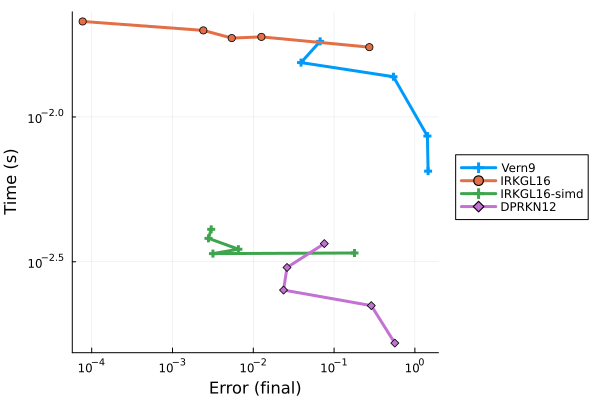

In [9]:
setups = [
          Dict(:alg=>Vern9())
]
solnames = ["Vern9"]
wp1 = WorkPrecisionSet(probdyn64,abstols,reltols,setups;appxsol=test_soldyn, save_everystep=false,numruns=10,maxiters=10^9, names=solnames);
plot(wp1);

#########################################################

setups = [
          Dict(:alg=>IRKGL16(second_order_ode=true,simd=false),:adaptive=>true)
          Dict(:alg=>IRKGL16(second_order_ode=true,simd=true),:adaptive=>true)
]
solnames = ["IRKGL16", "IRKGL16-simd" ]
wp2 = WorkPrecisionSet(prob64,abstols,reltols,setups;appxsol=test_sol,save_everystep=false,numruns=10,maxiters=10^9, names=solnames);
plot!(wp2);

#########################################################

setups = [
          Dict(:alg=>DPRKN12())   
]
solnames=["DPRKN12"]
wp3 = WorkPrecisionSet(prob2nd64,abstols,reltols,setups;appxsol=test_solx2nd,save_everystep=false,numruns=10,maxiters=10^9,name=solnames)
plot!(wp3)

<a href="#top">Back to the top</a>

## Work-Precision diagrams (Float128)

In [10]:
setprecision(BigFloat, 108)
abstols = 1.0 ./ 10.0 .^ (12:30)
reltols = 1.0 ./ 10.0 .^ (12:30);

### Second Order ODE: Vern9, IRKGL16, DPRKN12

In [ ]:
setups = [
          Dict(:alg=>Vern9())
]
solnames = ["Vern9"]
wp11 = WorkPrecisionSet(probdyn128,abstols,reltols,setups;appxsol=test_soldyn, save_everystep=false,numruns=10,maxiters=10^9, names=solnames);
plot(wp11);

#########################################################

setups = [
          Dict(:alg=>IRKGL16(second_order_ode=true),:adaptive=>true)
          Dict(:alg=>IRKGL16(second_order_ode=true,threading=true),:adaptive=>true)
]
solnames = ["IRKGL16", "IRKGL16-thread" ]
wp12 = WorkPrecisionSet(prob128,abstols,reltols,setups;appxsol=test_sol,save_everystep=false,numruns=10,maxiters=10^9, names=solnames);
plot!(wp12);

#########################################################

setups = [
          Dict(:alg=>DPRKN12())   
]
solnames=["DPRKN12"]
wp13 = WorkPrecisionSet(prob2nd128,abstols,reltols,setups;appxsol=test_solx2nd,save_everystep=false,numruns=10,maxiters=10^9,name=solnames)
plot!(wp13)

<a href="#top">Back to the top</a>